# A2Perf System and Reliability Metrics


In [1]:
!pip install tensorboard sns tbparse matplotlib pandas scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import collections
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorboard as tb
import tensorflow as tf
from packaging import version
from scipy import stats

2023-11-07 20:52:56.315597: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 20:52:56.318058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 20:52:56.343461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 20:52:56.343491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 20:52:56.343507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.14.1


In [4]:
base_dir = '/home/ikechukwuu/workspace/gcs/a2perf/'
debug = False

algo_to_exp_dict = dict(
    ppo='0013',
    ddpg='0025'
)
domain = 'quadruped_locomotion'
task = 'dog_pace'

seeds_to_process = [37, 14, 82,
                    23, 65, 98
                    ]

## Reliability Metrics

In [5]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '', task)

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/tensorboard/{algo.upper()}_0_1/*events*')
    print(f'Experiment Path: {experiment_path}')

    log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if any([f'seed_{seed}' in log_dir for seed in seeds_to_process])]
log_dirs

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/**/tensorboard/PPO_0_1/*events*
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/tensorboard/DDPG_0_1/*events*


['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699321829.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699236213.locomotion-2',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699231799.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_23_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699321883.locomotion-2',
 '/home/ikechukwuu/workspace/gcs/a2p

In [6]:
print(len(log_dirs))

12


### Pack Data into DataFrame

In [28]:
def load_tb_data(event_file):
    iterations_data = dict()
    ep_rew_data = dict()
    timestamp_data = dict()

    for event in tf.compat.v1.train.summary_iterator(event_file):

        # get the timestamp of the evnet
        timestamp = event.wall_time

        # Convert the timestamp to a datetime object
        timestamp = pd.to_datetime(timestamp, unit='s')
        timestamp_data[event.step] = timestamp

        for value in event.summary.value:
            # Check for episode_reward in the event
            if value.tag == 'episode_reward':
                if event.step in ep_rew_data:
                    raise ValueError(f'Found duplicate episode_reward data for step: {event.step}')
                ep_rew_data[event.step] = value.simple_value

            # Check for iterations in the event
            if value.tag == 'iterations':
                if event.step in iterations_data:
                    raise ValueError(f'Found duplicate iterations data for step: {event.step}')
                iterations_data[event.step] = value.simple_value

    df = pd.DataFrame.from_dict(iterations_data, orient='index', columns=['iterations'])
    df['episode_reward'] = df['iterations'].map(ep_rew_data)
    df['timestamp'] = df['iterations'].map(timestamp_data)
    df = df.reset_index()
    df = df.rename(columns={'index': 'step'})
    df = df.drop(columns=['iterations'])
    df['step'] = df['step'].astype(int)
    return df



In [29]:
all_df = pd.DataFrame()
for log_dir in log_dirs:
    log_base_dir = os.path.dirname(log_dir)
    exp_split = log_dir.split('/')

    exp_name = exp_split[-4]
    exp_name_split = exp_name.split('_')

    seed = exp_name_split[-5]
    experiment = exp_split[-5]
    algo = exp_split[-6]
    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

    data = load_tb_data(log_dir)
    data['seed'] = seed
    data['experiment'] = experiment
    data['algo'] = algo

    print(f'\tSaving data.csv to {log_base_dir}')
    data.to_csv(os.path.join(log_base_dir, 'data.csv'))

    print(f'\tFinished processing {log_dir}')
    print(f'\tNumber of rows: {len(data)}')

    # Print out the last global step value
    print(f'\tLast global step value: {data["step"].iloc[-1]}')
    all_df = pd.concat([all_df, data])




Processing Experiment: 0013, Seed: 65, Algo: ppo
	Saving data.csv to /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1
	Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699321829.locomotion-0
	Number of rows: 47059
	Last global step value: 47058
Processing Experiment: 0013, Seed: 14, Algo: ppo
	Saving data.csv to /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1
	Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed

In [31]:
for algo in algo_to_exp_dict.keys():
    algo_df = all_df[all_df['algo'] == algo]
    print(f'Algo: {algo}, Number of rows: {len(algo_df)}')

    # also get number of seeds
    print(f'Number of seeds: {len(algo_df["seed"].unique())}')


Algo: ppo, Number of rows: 282354
Number of seeds: 6
Algo: ddpg, Number of rows: 280704
Number of seeds: 6


In [32]:
for algo in algo_to_exp_dict.keys():
    df = all_df[all_df['algo'] == algo]
    print(f'Algo: {algo}')
    for seed, group in df.groupby('seed'):
        print(f'\tSeed: {seed}')
        diff = group['step'].diff()
        print(f'\t\tMin diff: {diff.min()}')
        print(f'\t\tMax diff: {diff.max()}')
        print(f'\t\tMedian diff: {diff.median()}')
        print(f'\t\tMean diff: {diff.mean()}')

Algo: ppo
	Seed: 14
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 23
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 37
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 82
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
Algo: ddpg
	Seed: 14
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 23
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 37
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 82
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0


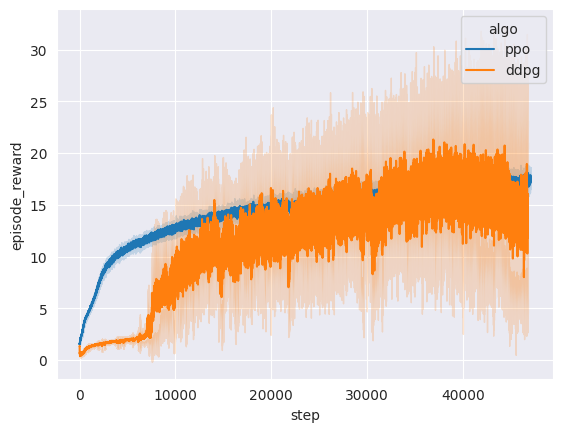

In [33]:
# plot both algorithms but group by the seeds to get mean and standard deviation
axes = sns.lineplot(x='step', y='episode_reward', hue='algo', data=all_df, errorbar='sd')

### Determining the score thresholds for difficulties

In [34]:
novice_score = all_df['episode_reward'].quantile(0.25)
intermediate_score = all_df['episode_reward'].quantile(0.5)
expert_score = all_df['episode_reward'].quantile(0.75)
print(f'novice Score Threshold: {novice_score}')
print(f'Intermediate Score Threshold: {intermediate_score}')
print(f'Expert Score Threshold: {expert_score}')

Beginner Score Threshold: 10.217942953109741
Intermediate Score Threshold: 14.140124797821045
Expert Score Threshold: 16.31248664855957


In [37]:
levels_df = pd.DataFrame()

for algo in algo_to_exp_dict.keys():
    policies_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                 f'**/policies/*_steps.zip')
    policies_paths = glob.glob(policies_path, recursive=True)

    policy_path_df = pd.DataFrame(policies_paths, columns=['path'])
    policy_path_df['step'] = policy_path_df['path'].str.extract(r'(\d+)_steps.zip', expand=False)
    policy_path_df['step'] = policy_path_df['step'].astype(int)
    policy_path_df['step'] = policy_path_df['step'] // 4096
    policy_path_df = policy_path_df.sort_values(by='step')
    policy_path_df['algo'] = algo
    policy_path_df['experiment'] = policy_path_df['path'].str.split('/').str[-4]
    policy_path_df['seed'] = policy_path_df['path'].str.split('/').str[-3].str.split('_').str[-5]

    # Now we can simply inner join with the all_df dataframe to get the score at each step
    policy_path_df = policy_path_df.merge(all_df[['step', 'episode_reward', 'seed', 'algo', 'timestamp']],
                                          on=['step', 'seed', 'algo'], how='inner')

    # ADd a 'level' column to the policy_path_df
    policy_path_df['level'] = 'expert'

    # now label the policies as novice, intermediate, or expert
    policy_path_df.loc[policy_path_df['episode_reward'] <= novice_score, 'level'] = 'novice'
    policy_path_df.loc[(policy_path_df['episode_reward'] > novice_score) & (
            policy_path_df['episode_reward'] <= intermediate_score), 'level'] = 'intermediate'

    levels_df = pd.concat([levels_df, policy_path_df])



In [38]:
TOP_K = 2

# This should give us the TOP_K policies for each algo and level
top_k_policies_df = (levels_df.groupby(['algo', 'level'])
                     .apply(lambda x: x.nlargest(TOP_K, 'episode_reward'))
                     .reset_index(drop=True))
top_k_policies_df

,path,step,algo,experiment,seed,episode_reward,timestamp,level
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,41205,ddpg,0025,37,10.215367,2023-10-22 11:04:28.421474816,beginner
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,45374,ddpg,0025,37,10.208971,2023-10-22 12:41:26.269952768,beginner
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0025,65,33.552414,2023-10-23 08:04:16.115435776,expert
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,42922,ddpg,0025,65,33.441456,2023-10-23 09:08:17.998457344,expert
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0025,23,14.121533,2023-10-23 07:46:34.186131712,intermediate
5,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,45129,ddpg,0025,23,14.117269,2023-10-23 09:49:33.123604736,intermediate
6,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,4390,ppo,0013,65,10.166745,2023-11-07 02:34:18.402626816,beginner
7,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,4633,ppo,0013,23,10.141152,2023-11-07 02:38:07.959378688,beginner
8,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,43891,ppo,0013,14,18.491392,2023-11-06 09:44:10.351939072,expert
9,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,40965,ppo,0013,98,18.314987,2023-11-07 08:52:24.645062144,expert


In [93]:

SKILL_LEVEL_TO_POLICY_STEP = dict()
for algo in algo_to_exp_dict.keys():
    SKILL_LEVEL_TO_POLICY_STEP[algo] = dict()
    for level in ('novice', 'intermediate', 'expert'):
        level_paths = top_k_policies_df[top_k_policies_df['level'] == level]['path'].values
        SKILL_LEVEL_TO_POLICY_STEP[algo][level] = list(level_paths)

print(SKILL_LEVEL_TO_POLICY_STEP)

{'ppo': {'beginner': ['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/quadruped_locomotion_int_eval_freq_1000000_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/policies/rl_policy_168777000_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/quadruped_locomotion_int_eval_freq_1000000_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/policies/rl_policy_185855625_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/policies/rl_policy_17981750_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_23_total_env_steps_200000000/policies/rl_policy_18980500_steps.zip'], 'intermediate': ['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomot

### Computing Window Size

In [50]:
EVAL_POINTS_PER_WINDOW = 5
med_step_diffs = []
for algo in algo_to_exp_dict.keys():
    algo_df = all_df[all_df['algo'] == algo]
    algo_grouped = algo_df.groupby('seed')
    for seed, group in algo_grouped:
        mean_step_diff = group['step'].diff().mean()
        median_step_diff = group['step'].diff().median()
        window_size = int(EVAL_POINTS_PER_WINDOW * median_step_diff)
        print(f'Seed: {seed}')
        print(f'\tMean step difference: {mean_step_diff}')
        print(f'\tMedian step difference: {median_step_diff}')
        print(f'\tWindow size: {window_size}')
        med_step_diffs.append(median_step_diff)

Seed: 14
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 23
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 37
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 82
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 14
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 23
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 37
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 82
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5


In [51]:
window_size = int(EVAL_POINTS_PER_WINDOW * np.mean(med_step_diffs))
avg_step_diff = int(np.mean(med_step_diffs))
window_size, avg_step_diff

(5, 1)

### Computing Reliability Metrics

In [52]:
eval_points = list(range(np.ceil(window_size / 2).astype(int), max(all_df['step']), avg_step_diff))
eval_points


[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


In [53]:
all_training_metrics = collections.defaultdict(dict)

In [54]:
window_fn = stats.iqr

for algo in algo_to_exp_dict.keys():
    all_iqr_values = []
    number_valid_eval_points = []

    print(f'Processing algo: {algo}')
    algo_filtered_df = all_df[all_df['algo'] == algo]
    for seed in seeds_to_process:
        windows_to_evaluate = []
        print(f'\tProcessing seed: {seed}')
        seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
        seed_filtered_df['episode_reward_diff'] = seed_filtered_df['episode_reward'].diff()
        seed_filtered_df = seed_filtered_df[['step', 'episode_reward_diff']]
        seed_filtered_df = seed_filtered_df.dropna()
        print('\t\tNumber of rows: ', len(seed_filtered_df))
        steps, episode_reward_diff = seed_filtered_df.to_numpy().T
        for eval_point in eval_points:
            low_end = np.ceil(eval_point - (window_size / 2))
            high_end = np.floor(eval_point + (window_size / 2))

            eval_points_above = steps >= low_end
            eval_points_below = steps <= high_end
            eval_points_in_window = np.logical_and(eval_points_above, eval_points_below)
            valid_eval_points = np.nonzero(eval_points_in_window)[0]

            if len(valid_eval_points) == 0:
                # print(f'\t\tNo valid eval points for eval point: {eval_point}')
                # print(f'Stopping since that means current seed is done')
                break

            number_valid_eval_points.append(len(valid_eval_points))
            windows_to_evaluate.append(valid_eval_points)
        iqr_values = [window_fn(episode_reward_diff[window]) for window in windows_to_evaluate]
        all_iqr_values.extend(iqr_values)
        # print(f'\t\tOn average there were {np.mean(number_valid_eval_points)} valid eval points per window')
        # print(f'\t\tMean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
        # print(f'\t\tMedian IQR: {median_iqr}')

    all_training_metrics[algo]['iqr'] = dict(
        mean=np.mean(all_iqr_values),
        std=np.std(all_iqr_values)
    )
    print(f'\tAll mean iqr values: {np.mean(all_iqr_values)} +/- {np.std(all_iqr_values)}')


Processing algo: ppo
	Processing seed: 37
		Number of rows:  47058
	Processing seed: 14
		Number of rows:  47058
	Processing seed: 82
		Number of rows:  47058
	Processing seed: 23
		Number of rows:  47058
	Processing seed: 65
		Number of rows:  47058
	Processing seed: 98
		Number of rows:  47058
	All mean iqr values: 0.6242553479819345 +/- 0.4131664509544277
Processing algo: ddpg
	Processing seed: 37
		Number of rows:  46783
	Processing seed: 14
		Number of rows:  46783
	Processing seed: 82
		Number of rows:  46783
	Processing seed: 23
		Number of rows:  46783
	Processing seed: 65
		Number of rows:  46783
	Processing seed: 98
		Number of rows:  46783
	All mean iqr values: 3.0460042751314402 +/- 2.9352759306617484



##### Long-term risk across time
Long - term risk across time represents the propensity of the agent to crash after achieving a higher performance measure

In [55]:
def compute_drawdown(sequence):
    """Computes the drawdown for a sequence of numbers.

      The drawdown at time T is the decline from the highest peak occurring at or
      before time T. https://en.wikipedia.org/wiki/Drawdown_(economics).

      The drawdown is always non-negative. A larger (more positive) drawdown
      indicates a larger drop.

    Args:
      sequence: A numpy array.

    Returns:
      A numpy array of same length as the original sequence, containing the
        drawdown at each timestep.
    """
    peak_so_far = np.maximum.accumulate(sequence)
    return peak_so_far - sequence

In [56]:
alpha = 0.95

for algo in algo_to_exp_dict.keys():
    all_cvars = []
    all_drawdowns = []
    print(f'Processing algo: {algo}')
    algo_filtered_df = all_df[all_df['algo'] == algo]
    for seed in seeds_to_process:
        print(f'\tProcessing seed: {seed}')

        seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
        seed_filtered_df = seed_filtered_df.sort_values(by='step')
        # Compute the drawdowns
        episode_rewards = seed_filtered_df['episode_reward'].values
        drawdowns = compute_drawdown(episode_rewards)
        all_drawdowns.extend(drawdowns)
        # Get the bottom "alpha" percent of drawdowns (we use the 95th percentile to get the bottom 5% of drawdowns)
        top_alpha_percent = np.percentile(drawdowns, alpha * 100)

        # CVaR is the average of the bottom "alpha" percent of drawdowns
        # cvar = np.mean(drawdowns[drawdowns <= bottom_alpha_percent]) we actually need greater than
        cvar = np.mean(drawdowns[drawdowns >= top_alpha_percent])
        all_cvars.append(cvar)
        print(f'\t\tCVaR: {cvar}')

    #now show overall mean and std of all cvars
    print(f'\tAll CVaR values: {all_cvars}')
    print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')
    all_training_metrics[algo]['long_term_risk'] = dict(
        mean=np.mean(all_cvars),
        std=np.std(all_cvars)
    )
    # now compute the cvar of all drawdowns together
    all_drawdowns = np.array(all_drawdowns)
    top_alpha_percent = np.percentile(all_drawdowns, alpha * 100)
    cvar = np.mean(all_drawdowns[all_drawdowns >= top_alpha_percent])
    print(f'\tAll CVaR values: {cvar}')

Processing algo: ppo
	Processing seed: 37
		CVaR: 2.979554164171523
	Processing seed: 14
		CVaR: 2.9982871834997717
	Processing seed: 82
		CVaR: 2.9446795719307226
	Processing seed: 23
		CVaR: 3.319410231687949
	Processing seed: 65
		CVaR: 2.9781783197567506
	Processing seed: 98
		CVaR: 3.0443347719340843
	All CVaR values: [2.979554164171523, 2.9982871834997717, 2.9446795719307226, 3.319410231687949, 2.9781783197567506, 3.0443347719340843]
	Average CVaR value: 3.0440740404968003 +/- 0.12668257132732066
	All CVaR values: 3.059622094353901
Processing algo: ddpg
	Processing seed: 37
		CVaR: 8.739813243018256
	Processing seed: 14
		CVaR: 18.38433063901388
	Processing seed: 82
		CVaR: 23.06759529623211
	Processing seed: 23
		CVaR: 12.12918648393745
	Processing seed: 65
		CVaR: 22.649624312777295
	Processing seed: 98
		CVaR: 21.992646414347185
	All CVaR values: [8.739813243018256, 18.38433063901388, 23.06759529623211, 12.12918648393745, 22.649624312777295, 21.992646414347185]
	Average CVaR v

##### Short-term risk across time
Short - term risk across time represents how volatile the agent is from eval point to eval point

In [57]:
alpha = 0.05
for algo in algo_to_exp_dict.keys():
    all_cvars = []
    all_diffs = []
    print(f'Processing algo: {algo}')
    algo_filtered_df = all_df[all_df['algo'] == algo]
    for seed in seeds_to_process:
        print(f'\tProcessing seed: {seed}')

        seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == str(seed)].copy()
        seed_filtered_df = seed_filtered_df.sort_values(by='step')

        seed_filtered_df['episode_reward_diff'] = seed_filtered_df['episode_reward'].diff()
        seed_filtered_df = seed_filtered_df.dropna()

        episode_reward_diffs = seed_filtered_df['episode_reward_diff'].values
        all_diffs.extend(episode_reward_diffs)
        bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100, interpolation='linear')

        # CVaR is the average of the bottom "alpha" percent of diffs
        # cvar = np.mean(drawdowns[drawdowns <= top_alpha_percent])
        cvar = np.mean(episode_reward_diffs[episode_reward_diffs <= bottom_alpha_percent])
        all_cvars.append(cvar)
        print(f'\t\tCVaR: {cvar}')

    # Finally, report the mean and standard deviation of ALL the CVaR values in \pm notation
    print(f'\tAll CVaR values: {all_cvars}')
    print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')
    all_training_metrics[algo]['short_term_risk'] = dict(
        mean=np.mean(all_cvars),
        std=np.std(all_cvars)
    )

    # now compute the cvar of all diffs together
    all_diffs = np.array(all_diffs)
    bottom_alpha_percent = np.percentile(all_diffs, alpha * 100, interpolation='linear')
    cvar = np.mean(all_diffs[all_diffs <= bottom_alpha_percent])
    print(f'\tAll CVaR values: {cvar}')

Processing algo: ppo
	Processing seed: 37
		CVaR: -1.1795785342993454
	Processing seed: 14
		CVaR: -1.2211285670969874
	Processing seed: 82
		CVaR: -1.2298178504590425
	Processing seed: 23
		CVaR: -1.2578393690544547
	Processing seed: 65
		CVaR: -1.2124664685192181
	Processing seed: 98
		CVaR: -1.2495439924993161
	All CVaR values: [-1.1795785342993454, -1.2211285670969874, -1.2298178504590425, -1.2578393690544547, -1.2124664685192181, -1.2495439924993161]
	Average CVaR value: -1.2250624636547274 +/- 0.025622929025243206
	All CVaR values: -1.2257765066625377
Processing algo: ddpg
	Processing seed: 37
		CVaR: -4.193356613674735
	Processing seed: 14
		CVaR: -5.07676962387358
	Processing seed: 82
		CVaR: -10.131944081467442
	Processing seed: 23
		CVaR: -6.420707880024217
	Processing seed: 65
		CVaR: -10.026841072037689
	Processing seed: 98
		CVaR: -7.269907101759544
	All CVaR values: [-4.193356613674735, -5.07676962387358, -10.131944081467442, -6.420707880024217, -10.026841072037689, -7.26


##### Risk across runs
Risk across runs tells use how poor the final performance of the worst runs are

In [58]:
# Get the final episode reward for each seed
final_episode_rewards = all_df.groupby(['algo', 'seed']).tail(1)
final_episode_rewards

,step,episode_reward,timestamp,seed,experiment,algo
47058,47058,17.199739,2023-11-07 09:41:36.798409216,65,0013,ppo
47058,47058,16.523844,2023-11-06 10:21:38.111316224,14,0013,ppo
47058,47058,17.635061,2023-11-06 09:19:15.205544448,37,0013,ppo
47058,47058,19.376165,2023-11-07 09:44:57.666209280,23,0013,ppo
47058,47058,17.624748,2023-11-06 10:05:01.224812288,82,0013,ppo
47058,47058,17.705460,2023-11-07 09:55:15.187414016,98,0013,ppo
46783,46783,26.492647,2023-10-23 10:20:08.781629440,65,0025,ddpg
46783,46783,4.140475,2023-10-23 10:27:57.158656000,98,0025,ddpg
46783,46783,17.735746,2023-10-23 10:20:04.306670592,23,0025,ddpg
46783,46783,9.503802,2023-10-22 13:07:43.276666880,37,0025,ddpg


In [59]:
# Compute the CVaR of final episode rewards for each algo
alpha = 0.05
for algo in algo_to_exp_dict.keys():
    algo_final_episode_rewards = final_episode_rewards[final_episode_rewards['algo'] == algo]
    top_alpha_percent = np.percentile(algo_final_episode_rewards['episode_reward'].values, alpha * 100,
                                      interpolation='linear')
    cvar = np.mean(algo_final_episode_rewards['episode_reward'].values[
                       algo_final_episode_rewards['episode_reward'].values <= top_alpha_percent])
    print(f'Algo: {algo}, CVaR: {cvar}')
    all_training_metrics[algo]['risk_across_runs'] = cvar,


Algo: ppo, CVaR: 16.52384376525879
Algo: ddpg, CVaR: 4.140475273132324



#### Dispersion across runs


In [60]:
def lowpass_filter(curve, lowpass_thresh):
    filt_b, filt_a = scipy.signal.butter(8, lowpass_thresh)

    def butter_filter_fn(c):
        padlen = min(len(c) - 1, 3 * max(len(filt_a), len(filt_b)))
        return scipy.signal.filtfilt(filt_b, filt_a, curve, padlen=padlen)

    processed_curve = butter_filter_fn(curve)
    return processed_curve


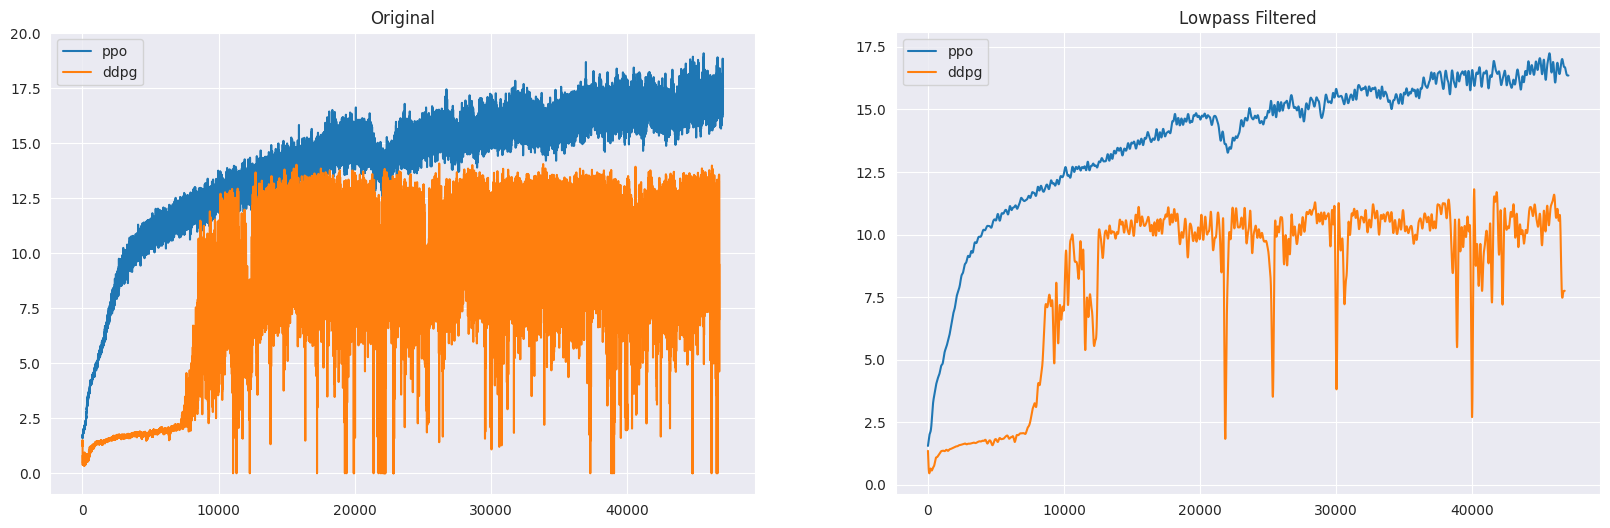

In [61]:
# Plot the first curve before and after lowpass filtering
# curve = ep_rew_clean[ep_rew_clean['seed'] == '37']['value'].values
# lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)

ppo_curve = all_df[(all_df['algo'] == 'ppo') & (all_df['seed'] == '37')]['episode_reward'].values

ddpg_curve = all_df[(all_df['algo'] == 'ddpg') & (all_df['seed'] == '37')]['episode_reward'].values

low_pass_ppo_curve = lowpass_filter(ppo_curve, lowpass_thresh=0.01)
low_pass_ddpg_curve = lowpass_filter(ddpg_curve, lowpass_thresh=0.01)

# plot both curves with the original on the left, and lowpass on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(ppo_curve)
axes[0].plot(ddpg_curve)
axes[0].set_title('Original')
axes[1].plot(low_pass_ppo_curve)
axes[1].plot(low_pass_ddpg_curve)
axes[1].set_title('Lowpass Filtered')

#add a legend so it's easy to read
axes[0].legend(['ppo', 'ddpg'])
axes[1].legend(['ppo', 'ddpg'])


In [62]:
# For each algo, compute a new df with the lowpass filtered curves
lowpass_df = pd.DataFrame()
for algo in algo_to_exp_dict.keys():
    algo_df = all_df[all_df['algo'] == algo]
    for seed, group in algo_df.groupby('seed'):
        curve = group['episode_reward'].values
        lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)
        group['lowpass_episode_reward'] = lowpass_curve
        lowpass_df = pd.concat([lowpass_df, group])

<Axes: xlabel='step', ylabel='lowpass_episode_reward'>

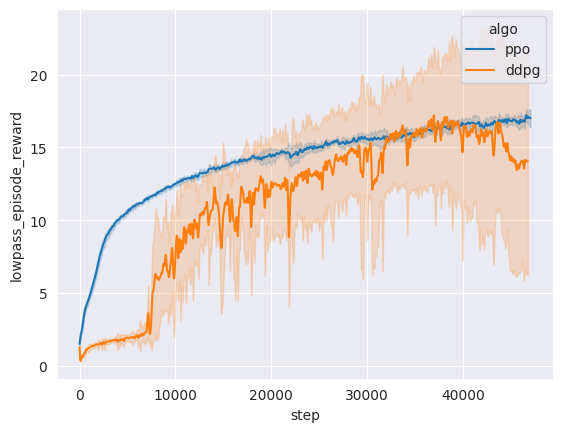

In [63]:
# plot both algorithms but group by the seeds to get mean and standard deviation
sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo', data=lowpass_df, errorbar='sd')

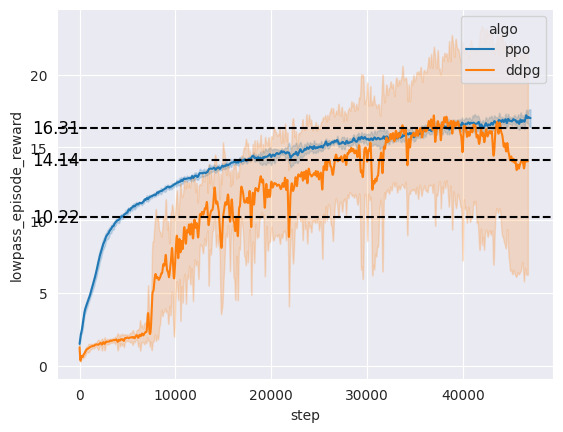

In [67]:
x = sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo', data=lowpass_df, errorbar='sd')
for loc in (novice_score, intermediate_score, expert_score):
    # draw horizontal lines and label the score thresholds
    x.axhline(loc, ls='--', color='black')
    x.text(0, loc, f'{loc:.2f}', ha='right', va='center', color='black', fontsize=12)


In [66]:
for algo in algo_to_exp_dict.keys():
    algo_df = lowpass_df[lowpass_df['algo'] == algo]

    # These computations are for dispersion ACROSS runs. We simply need to group by step and then compute the IQR
    # of the episode rewards at each step

    # First examine the group to make sure we get the same number of values as the number of seeds
    for step, group in algo_df.groupby('step'):
        assert len(group) == len(seeds_to_process), f'Expected {len(seeds_to_process)} values but got {len(group)}'

    # Now compute the IQR of the episode rewards at each step
    iqr_values = algo_df.groupby('step')['lowpass_episode_reward'].apply(stats.iqr)
    mean_iqr = iqr_values.mean()
    print(f'Algo: {algo}, Mean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
    all_training_metrics[algo]['dispersion_across_runs'] = dict(
        mean=mean_iqr,
        std=np.std(iqr_values)
    )

Algo: ppo, Mean IQR: 0.3037523571645606 +/- 0.17640888325961968
Algo: ddpg, Mean IQR: 4.35495987642417 +/- 2.504008022537317


## System Metrics

In [68]:
# Load all of the system metrics using glob and pandas csv

system_metric_dirs = []

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/train_emissions.csv')
    print(f'Experiment Path: {experiment_path}')

    system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0013/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/train_emissions.csv


In [69]:
len(system_metric_dirs)

12

In [70]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
    split_dir = metric_dir.split('/')
    exp_name = split_dir[-3]
    exp_name_split = exp_name.split('_')
    print(exp_name_split)
    seed = exp_name_split[-5]
    experiment = split_dir[-4]
    algo = split_dir[-5]

    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

    df = pd.read_csv(metric_dir)
    df['seed'] = seed
    df['experiment'] = experiment
    df['algo'] = algo

    system_metrics_df = pd.concat([system_metrics_df, df])


['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '65', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0013, Seed: 65, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '14', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0013, Seed: 14, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '37', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0013, Seed: 37, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '23', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0013, Seed: 23, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '82', 'total', 'env', 'steps', '200000000']
Processing Experiment: 0013, Seed: 82, Algo: ppo
['quadruped', 'locomotion', 'int', 'save', 'f

In [71]:
mean_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()
std_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].std()

# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    # make into hours please
    mean_duration[algo] /= 3600
    std_duration[algo] /= 3600
    print(f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')
    all_training_metrics[algo]['duration'] = dict(
        mean=mean_duration[algo],
        std=std_duration[algo]
    )

Algo: ppo, Mean Duration: 8.118665611302411 +/- 0.24306610400425216
Algo: ddpg, Mean Duration: 15.494186520013544 +/- 0.21334370520891233


In [72]:
duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()

In [73]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
    all_training_metrics[algo]['peak_ram'] = dict(
        mean=mean_peak_ram[algo],
        std=std_peak_ram[algo]
    )

Algo: ppo, Mean Peak RAM: 162.36878140767416 +/- 0.04386659177065393
Algo: ddpg, Mean Peak RAM: 474.8679993947347 +/- 0.42848573579269467


In [74]:
# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')
    all_training_metrics[algo]['mean_ram'] = dict(
        mean=mean_ram[algo],
        std=std_ram[algo]
    )

Algo: ppo, Mean RAM: 162.28988887289458 +/- 2.5519557166122278
Algo: ddpg, Mean RAM: 357.2859432333534 +/- 89.53247248389125


## Computing the Training Sample Cost


In [87]:
# Line up the step values for each algorithm with the system metrics
top_k_policies_df['true_step'] = top_k_policies_df['step'] * 4096

top_k_policies_df = top_k_policies_df.sort_values('timestamp')
system_metrics_df = system_metrics_df.sort_values('timestamp')
assert (top_k_policies_df['true_step'] < 2e8).all(), 'Found a step value greater than 200 million'

top_k_policies_df

,path,step,algo,experiment,seed,episode_reward,timestamp,level,true_step
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,41205,ddpg,0025,37,10.215367,2023-10-22 11:04:28.421474816,beginner,168775680
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,45374,ddpg,0025,37,10.208971,2023-10-22 12:41:26.269952768,beginner,185851904
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0025,23,14.121533,2023-10-23 07:46:34.186131712,intermediate,161742848
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0025,65,33.552414,2023-10-23 08:04:16.115435776,expert,161742848
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,42922,ddpg,0025,65,33.441456,2023-10-23 09:08:17.998457344,expert,175808512
5,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,45129,ddpg,0025,23,14.117269,2023-10-23 09:49:33.123604736,intermediate,184848384
11,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,15362,ppo,0013,82,14.133173,2023-11-06 04:38:32.953916416,intermediate,62922752
10,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,22190,ppo,0013,14,14.139791,2023-11-06 05:51:46.660408064,intermediate,90890240
8,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,43891,ppo,0013,14,18.491392,2023-11-06 09:44:10.351939072,expert,179777536
6,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,4390,ppo,0013,65,10.166745,2023-11-07 02:34:18.402626816,beginner,17981440


In [88]:
system_metrics_df['timestamp'] = pd.to_datetime(system_metrics_df['timestamp'])
pd.merge_asof(top_k_policies_df, system_metrics_df, left_on='timestamp', right_on='timestamp', direction='nearest', )

,path,step,algo_x,experiment_x,seed_x,episode_reward,timestamp,level,true_step,project_name,...,gpu_model,longitude,latitude,ram_total_size,ram_process,tracking_mode,on_cloud,seed_y,experiment_y,algo_y
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,41205,ddpg,0025,37,10.215367,2023-10-22 11:04:28.421474816,beginner,168775680,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290115,475.333710,process,N,82,0025,ddpg
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,45374,ddpg,0025,37,10.208971,2023-10-22 12:41:26.269952768,beginner,185851904,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290138,475.194176,process,N,14,0025,ddpg
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0025,23,14.121533,2023-10-23 07:46:34.186131712,intermediate,161742848,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290138,468.418324,process,N,98,0025,ddpg
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0025,65,33.552414,2023-10-23 08:04:16.115435776,expert,161742848,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290115,474.339382,process,N,23,0025,ddpg
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,42922,ddpg,0025,65,33.441456,2023-10-23 09:08:17.998457344,expert,175808512,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290150,474.256283,process,N,65,0025,ddpg
5,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,45129,ddpg,0025,23,14.117269,2023-10-23 09:49:33.123604736,intermediate,184848384,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290150,474.279289,process,N,65,0025,ddpg
6,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,15362,ppo,0013,82,14.133173,2023-11-06 04:38:32.953916416,intermediate,62922752,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290176,162.292934,process,N,14,0013,ppo
7,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,22190,ppo,0013,14,14.139791,2023-11-06 05:51:46.660408064,intermediate,90890240,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290184,162.346813,process,N,37,0013,ppo
8,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,43891,ppo,0013,14,18.491392,2023-11-06 09:44:10.351939072,expert,179777536,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290192,162.316551,process,N,82,0013,ppo
9,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,4390,ppo,0013,65,10.166745,2023-11-07 02:34:18.402626816,beginner,17981440,rlperf_quadruped_locomomtion_train,...,NaN,NaN,NaN,1417.290184,162.320301,process,N,65,0013,ppo


---

# Inference Metrics


In [26]:
import collections

all_inference_metrics = collections.defaultdict(dict)

In [27]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '', task)

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/inference_metric_results.json')
    print(f'Experiment Path: {experiment_path}')

    log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if any([f'seed_{seed}' in log_dir for seed in seeds_to_process])]
len(log_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/**/inference_metric_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/inference_metric_results.json


12

In [28]:
# Load each of the inference metric results into a dataframe
import collections

all_metrics_df = collections.defaultdict(pd.DataFrame)
for algo, exps in algo_to_exp_dict.items():
    algo_log_dirs = [log_dir for log_dir in log_dirs if algo in log_dir]

    for log_dir in algo_log_dirs:
        split_dir = os.path.normpath(log_dir).split(os.sep)
        exp_name = split_dir[-4]
        exp_name_split = exp_name.split('_')
        seed = exp_name_split[-5]
        experiment = split_dir[-5]

        print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')
        assert algo == split_dir[-6], f'algo: {algo}, split_dir[-6]: {split_dir[-6]}'

        data = json.load(open(log_dir))

        for task, metrics in data.items():
            for metric, values in metrics.items():
                df = pd.DataFrame.from_dict(values, orient='columns', )
                df['task'] = task
                df['seed'] = seed
                df['experiment'] = experiment
                df['algo'] = algo
                df['metric'] = metric
                all_metrics_df[metric] = pd.concat([all_metrics_df[metric], df])

Processing Experiment: 0006, Seed: 65, Algo: ppo
Processing Experiment: 0006, Seed: 14, Algo: ppo
Processing Experiment: 0006, Seed: 37, Algo: ppo
Processing Experiment: 0006, Seed: 23, Algo: ppo
Processing Experiment: 0006, Seed: 82, Algo: ppo
Processing Experiment: 0006, Seed: 98, Algo: ppo
Processing Experiment: 0025, Seed: 65, Algo: ddpg
Processing Experiment: 0025, Seed: 98, Algo: ddpg
Processing Experiment: 0025, Seed: 23, Algo: ddpg
Processing Experiment: 0025, Seed: 37, Algo: ddpg
Processing Experiment: 0025, Seed: 82, Algo: ddpg
Processing Experiment: 0025, Seed: 14, Algo: ddpg


In [29]:
system_metric_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '', task)

for algo in algo_to_exp_dict.keys():
    experiment_path = os.path.join(experiment_base_dir, algo, algo_to_exp_dict[algo],
                                   f'**/inference_emissions.csv')
    print(f'Experiment Path: {experiment_path}')

    system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))
len(system_metric_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0006/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0025/**/inference_emissions.csv


12

In [30]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
    split_dir = metric_dir.split('/')
    exp_name = split_dir[-4]
    exp_name_split = exp_name.split('_')
    # print(exp_name_split)
    seed = exp_name_split[-5]
    experiment = split_dir[-5]
    algo = split_dir[-6]

    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

    df = pd.read_csv(metric_dir)
    df['seed'] = seed
    df['experiment'] = experiment
    df['algo'] = algo

    system_metrics_df = pd.concat([system_metrics_df, df])

Processing Experiment: 0006, Seed: 65, Algo: ppo
Processing Experiment: 0006, Seed: 14, Algo: ppo
Processing Experiment: 0006, Seed: 37, Algo: ppo
Processing Experiment: 0006, Seed: 23, Algo: ppo
Processing Experiment: 0006, Seed: 82, Algo: ppo
Processing Experiment: 0006, Seed: 98, Algo: ppo
Processing Experiment: 0025, Seed: 65, Algo: ddpg
Processing Experiment: 0025, Seed: 98, Algo: ddpg
Processing Experiment: 0025, Seed: 23, Algo: ddpg
Processing Experiment: 0025, Seed: 37, Algo: ddpg
Processing Experiment: 0025, Seed: 82, Algo: ddpg
Processing Experiment: 0025, Seed: 14, Algo: ddpg


## System Metrics


In [31]:
mean_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].mean()
std_duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')['duration'].std()

In [32]:
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')

    all_inference_metrics[algo]['duration'] = dict(
        mean=mean_duration[algo],
        std=std_duration[algo]
    )

Algo: ppo, Mean Duration: 32.27398705482483 +/- 0.884119428599402
Algo: ddpg, Mean Duration: 17.434075673421223 +/- 0.44717434472660006


In [33]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])['ram_process'].max().groupby('algo').std()

In [34]:
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
    all_inference_metrics[algo]['peak_ram'] = dict(
        mean=mean_peak_ram[algo],
        std=std_peak_ram[algo]
    )

# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
    print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')
    all_inference_metrics[algo]['mean_ram'] = dict(
        mean=mean_ram[algo],
        std=std_ram[algo]
    )

Algo: ppo, Mean Peak RAM: 0.9345887502034506 +/- 0.17936479633436947
Algo: ddpg, Mean Peak RAM: 0.8049786885579427 +/- 0.0010263128523353092
Algo: ppo, Mean RAM: 0.8418324528908243 +/- 0.09978895802704903
Algo: ddpg, Mean RAM: 0.7981020552000848 +/- 0.007130004306887121


In [35]:
for metric, df in all_metrics_df.items():
    # Get the mean and standard deviation of the metric for each algo
    for algo, group in df.groupby('algo'):
        mean = group['values'].mean()
        std = group['values'].std()
        # use tabs to make it easier to read
        print(f'Algo: {algo}\tMetric: {metric}\tMean: {mean}\tStd: {std}')
        all_inference_metrics[algo][metric] = dict(
            mean=mean,
            std=std
        )
    print('-' * 50)  # A separator for easier reading

Algo: ddpg	Metric: inference_time	Mean: 0.00018185474818892543	Std: 0.000285570506153258
Algo: ppo	Metric: inference_time	Mean: 0.00023998617234550086	Std: 0.000461083491166053
--------------------------------------------------
Algo: ddpg	Metric: rollout_returns	Mean: 2.5285100480062743	Std: 0.5375832643483126
Algo: ppo	Metric: rollout_returns	Mean: 17.634169250701135	Std: 5.03177683130362
--------------------------------------------------


## Reliability Metrics

#### Dispersion across rollouts


In [36]:
# Simply compute the IQR of the rollouts for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
    iqr = scipy.stats.iqr(group['values'].values)
    #use tabs to make it easier to read
    print(f'Algo: {algo}\tIQR: {iqr}')
    all_inference_metrics[algo]['dispersion_across_rollouts'] = iqr



Algo: ddpg	IQR: 0.7354651949258928
Algo: ppo	IQR: 6.108751338599976


#### Risk across rollouts

In [37]:
# Simply compute the CVaR of the rollouts for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
    # Get the bottom "alpha" percent of rollouts (we use the 5th percentile to get the bottom 5% of rollouts)
    bottom_alpha_percent = np.percentile(group['values'].values, 5)
    # CVaR is the average of the bottom "alpha" percent of rollouts
    cvar = np.mean(group['values'].values[group['values'].values <= bottom_alpha_percent])
    #use tabs to make it easier to read
    print(f'Algo: {algo}\tCVaR: {cvar}')
    all_inference_metrics[algo]['risk_across_rollouts'] = cvar


Algo: ddpg	CVaR: 1.5762048145773229
Algo: ppo	CVaR: 9.983162434379846


#### Returns 

In [38]:
# Simply compute the average return for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
    mean = group['values'].mean()
    std = group['values'].std()
    #use tabs to make it easier to read
    print(f'Algo: {algo}\tMean: {mean}\tStd: {std}')
    all_inference_metrics[algo]['rollout_returns'] = dict(
        mean=mean,
        std=std
    )

Algo: ddpg	Mean: 2.5285100480062743	Std: 0.5375832643483126
Algo: ppo	Mean: 17.634169250701135	Std: 5.03177683130362


# Display all metrics nicely

In [99]:
for algo, metrics in all_training_metrics.items():
    print(f'Algo: {algo}')
    for metric, values in metrics.items():
        if isinstance(values, dict):
            mean = values['mean']
            std = values['std']
            print(f'\tMetric: {metric}\tMean: {mean}\tStd: {std}')
        else:
            print(f'\tMetric: {metric}\tValue: {values}')
    print('-' * 50)  # A separator for easier reading

Algo: ppo
	Metric: iqr	Mean: 0.6404025417996767	Std: 0.4272473660427797
	Metric: long_term_risk	Mean: 3.029113356258869	Std: 0.11685174517095022
	Metric: short_term_risk	Mean: -1.2555233044054663	Std: 0.028320272440977304
	Metric: risk_across_runs	Value: (16.759601593017578,)
	Metric: dispersion_across_runs	Mean: 0.34164010136642514	Std: 0.18063457071948175
	Metric: duration	Mean: 9.28810767141757	Std: 0.32456648285903517
	Metric: peak_ram	Mean: 132.40590540568033	Std: 0.021790319406040145
	Metric: mean_ram	Mean: 132.3020228140673	Std: 1.710937104588233
--------------------------------------------------
Algo: ddpg
	Metric: iqr	Mean: 3.0460042751314402	Std: 2.9352759306617484
	Metric: long_term_risk	Mean: 17.82719939822103	Std: 5.529117072269308
	Metric: short_term_risk	Mean: -7.1865877288062014	Std: 2.2637153127499587
	Metric: risk_across_runs	Value: (4.140475273132324,)
	Metric: dispersion_across_runs	Mean: 4.35495987642417	Std: 2.504008022537317
	Metric: duration	Mean: 15.49418652001

In [39]:
# print out all the inference metrics nicely with mean +/- std if they have that
for algo, metrics in all_inference_metrics.items():
    print(f'Algo: {algo}')
    for metric, values in metrics.items():
        if isinstance(values, dict):
            mean = values['mean']
            std = values['std']
            print(f'\tMetric: {metric}\tMean: {mean}\tStd: {std}')
        else:
            print(f'\tMetric: {metric}\tValue: {values}')
    print('-' * 50)  # A separator for easier reading

Algo: ppo
	Metric: duration	Mean: 32.27398705482483	Std: 0.884119428599402
	Metric: peak_ram	Mean: 0.9345887502034506	Std: 0.17936479633436947
	Metric: mean_ram	Mean: 0.8418324528908243	Std: 0.09978895802704903
	Metric: inference_time	Mean: 0.00023998617234550086	Std: 0.000461083491166053
	Metric: rollout_returns	Mean: 17.634169250701135	Std: 5.03177683130362
	Metric: dispersion_across_rollouts	Value: 6.108751338599976
	Metric: risk_across_rollouts	Value: 9.983162434379846
--------------------------------------------------
Algo: ddpg
	Metric: duration	Mean: 17.434075673421223	Std: 0.44717434472660006
	Metric: peak_ram	Mean: 0.8049786885579427	Std: 0.0010263128523353092
	Metric: mean_ram	Mean: 0.7981020552000848	Std: 0.007130004306887121
	Metric: inference_time	Mean: 0.00018185474818892543	Std: 0.000285570506153258
	Metric: rollout_returns	Mean: 2.5285100480062743	Std: 0.5375832643483126
	Metric: dispersion_across_rollouts	Value: 0.7354651949258928
	Metric: risk_across_rollouts	Value: 1

# Sandbox

In [174]:

all_metrics_df['rollout_returns']['values'].describe()

count    1200.000000
mean        2.055492
std         1.124505
min         0.526985
25%         1.288198
50%         1.883000
75%         2.598032
max         8.764867
Name: values, dtype: float64